# Note book imports

In [2]:
from os.path import exists, join
from os import walk
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Constants

In [3]:
EXAMPLE_FILE = "../spamData/01_Processing/practice_email.txt"
EASY_NONSPAM_1 = "../SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/"
EASY_NONSPAM_2 = "../SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/"
SPAM_1 = "../SpamData/01_Processing/spam_assassin_corpus/spam_1/"
SPAM_2 = "../SpamData/01_Processing/spam_assassin_corpus/spam_2/"

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE="../SpamData/01_Processing/email-text-data.json"

In [4]:
with open(EXAMPLE_FILE, "r", encoding="latin-1") as ex_in:
    is_body = False
    lines = []

    for line in ex_in.readlines():
        if is_body:
            lines.append(line)
        elif line == "\n":
            is_body = True
email_body = "".join(lines)
print(email_body)


Dear Mr Still

Good tidings to you and all your staff for the festive season ahead (Christmas).
Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.
But WAIT! You're probably thinking: "What makes him so special?"
Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.
You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.
I look forward to hearing from you.

Best wishes
Robin Cooper
[Excerpt from the book: The Timewaster Letters by Robi

## Generator function

In [5]:
def email_body_generator(rel_path: str):
    """"
    Walks a directory and yields each file from the directory
    :param rel_path: A relative path to a folder.
    :yield : A tuple of two strings, the file name and a body of an email
    """
    for root, dirnames, filenames in walk(rel_path):
        for file_name in filenames:
            file_path = join(root, file_name)
            with open(file_path, "r", encoding="latin-1") as ex_in:
                is_body = False
                lines = []

                for line in ex_in.readlines():
                    if is_body:
                        lines.append(line)
                    elif line == "\n":
                        is_body = True
            email_body = "".join(lines)
            yield file_name, email_body


In [6]:
def df_from_directory(rel_path: str, classification):
    """
    Loops through a generator function reading email body and names
    """
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(rel_path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [7]:
spam_emails = df_from_directory(SPAM_1, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2, SPAM_CAT))

ham_emails = df_from_directory(EASY_NONSPAM_1, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2, HAM_CAT))

C:\Users\scott\AppData\Local\Temp\ipykernel_6544\982421901.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails = spam_emails.append(df_from_directory(SPAM_2, SPAM_CAT))
C:\Users\scott\AppData\Local\Temp\ipykernel_6544\982421901.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2, HAM_CAT))


In [8]:
data = pd.concat([spam_emails, ham_emails])
print(f"Shape of entire df {data.shape}")

Shape of entire df (5799, 2)


## Data Cleaning: Checking for Missing Values

In [9]:
# Check for null message bodies
data.MESSAGE.isnull().values.any()

False

In [10]:
# Get number of None values
(data.MESSAGE.isnull()).sum()

0

In [11]:
# Check for empty emails (str len of 0)
any(data.MESSAGE.str.len() == 0)

True

In [12]:
# Number of empty emails
(data.MESSAGE.str.len()  == 0).sum()

3

## Locate empty emails

In [13]:
data[data.MESSAGE.str.len()  == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Remove system file entries from dataframe

In [14]:
data.drop(['cmds'], inplace=True)

In [15]:
data[data.MESSAGE.str.len()  == 0].index

Index([], dtype='object')

In [16]:
data.shape

(5796, 2)

## Add Document IDs to Track emails in dataset

In [17]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [18]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n1) Slim Down ...,1,00005.57696a39d7d84318ce497886896bf90d


## Save to File using Pandas

In [19]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualized (pie charts)

In [20]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

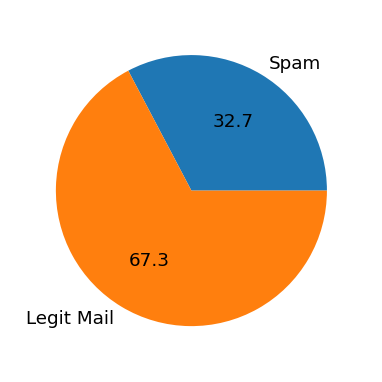

In [28]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
plt.figure(figsize=(2,2), dpi=220)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, autopct='%1.1f')
plt.show()

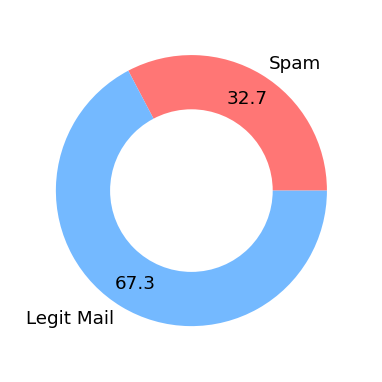

In [37]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ["#ff7675", "#74b9ff"]
plt.figure(figsize=(2,2), dpi=220)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, autopct='%1.1f', colors=custom_colors,  pctdistance=0.8)

# Draw circle
center_circle = plt.Circle((0, 0), radius=.6, fc="white")
plt.gca().add_artist(center_circle)

plt.show()

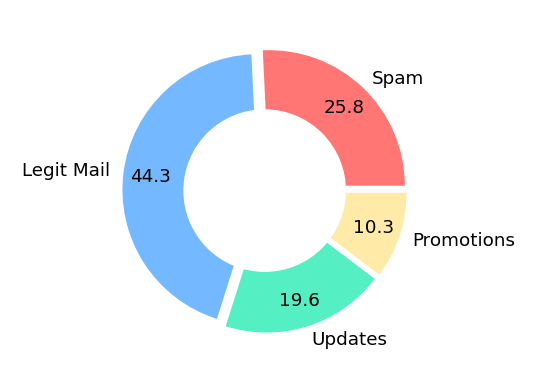

In [39]:
category_names = ["Spam", "Legit Mail", "Updates", "Promotions"]
sizes = [25, 43, 19, 10]
custom_colors = ["#ff7675", "#74b9ff", "#55efc4", "#ffeaa7"]
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=220)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, autopct='%1.1f', colors=custom_colors,  pctdistance=0.8, explode=offset)

# Draw circle
center_circle = plt.Circle((0, 0), radius=.6, fc="white")
plt.gca().add_artist(center_circle)

plt.show()